### 0. Directory setting

In [1]:
import os
import sys

notebook_dir = os.getcwd()

project_dir = notebook_dir
if os.path.basename(notebook_dir) == 'notebooks':
    project_dir = os.path.dirname(notebook_dir)
    os.chdir(project_dir)

if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    



### 1. Imports

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import logging

# Import custom modules
import sys
sys.path.append('./')
from utils.data_loader import load_data, load_anomaly_labels, normalize_data, create_sequences
from utils.data_loader import create_labels_array, split_data, prepare_data_loaders
from utils.model_utils import LSTMAutoencoder, GRUAutoencoder, TransformerEncoder, train_model
from utils.model_utils import get_reconstruction_errors, EnsembleModel, save_trained_models
from utils.evaluation import evaluate_threshold, AnomalyInterpreter, visualize_results
from utils.evaluation import plot_roc_curves, plot_precision_recall_curves, create_results_summary, print_results_table


### 2. Initial Configuration



In [3]:

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Usando dispositivo: {device}")


2025-05-23 21:37:40,107 - INFO - Usando dispositivo: cpu


### 3. Data Loading and Preprocessing

In [4]:

# Load and prepare data
filepath = 'data/machine_temperature_system_failure.csv'
labels_path = 'data/known_labels_v1.0.json'
windows_path = 'data/combined_windows.json'

df = load_data(filepath)
labels_dict, windows_dict = load_anomaly_labels(labels_path, windows_path)

filename = 'realKnownCause/machine_temperature_system_failure.csv'
anomaly_timestamps = labels_dict[filename]
anomaly_windows = windows_dict[filename]

data_scaled, scaler = normalize_data(df[['value']])


2025-05-23 21:37:40,115 - INFO - Charging data from data/machine_temperature_system_failure.csv
2025-05-23 21:37:40,139 - INFO - Charged data: 22695 registers
2025-05-23 21:37:40,139 - INFO - Charging labels from data/known_labels_v1.0.json and data/combined_windows.json


In [5]:

sequence_length = 150
step = 10

X = create_sequences(data_scaled, sequence_length, step)
y = create_labels_array(df, anomaly_timestamps, anomaly_windows, sequence_length, step)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

batch_size = 64
train_loader, val_loader, test_loader = prepare_data_loaders(X_train, X_val, X_test, batch_size)


2025-05-23 21:37:40,203 - INFO - Data division: Train 1578, Val 338, Test 339


### 4. Construct Models

In [6]:

# Train models
lstm_autoencoder = LSTMAutoencoder(seq_len=sequence_length, n_features=1, embedding_dim=64, dropout=0.2)
gru_autoencoder = GRUAutoencoder(seq_len=sequence_length, n_features=1, embedding_dim=64, dropout=0.2)
transformer_model = TransformerEncoder(seq_len=sequence_length, n_features=1, d_model=48, nhead=4,
                                       dropout=0.3, num_layers=2)

lstm_history, lstm_model = train_model(
    lstm_autoencoder, train_loader, val_loader, n_epochs=50, learning_rate=1e-3,
    device=device, patience=7, min_delta=0.0001, weight_decay=1e-5
)

gru_history, gru_model = train_model(
    gru_autoencoder, train_loader, val_loader, n_epochs=50, learning_rate=1e-3,
    device=device, patience=7, min_delta=0.0001, weight_decay=1e-5
)


2025-05-23 21:37:40,244 - INFO - Starting model training LSTMAutoencoder
C:\Users\aleja\AppData\Roaming\Python\Python313\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-05-23 21:37:46,014 - INFO - Epoch 1/50, Train Loss: 0.90601, Val Loss: 0.75215
2025-05-23 21:37:49,014 - INFO - Epoch 2/50, Train Loss: 0.79733, Val Loss: 0.63207
2025-05-23 21:37:52,190 - INFO - Epoch 3/50, Train Loss: 0.64935, Val Loss: 0.49851
2025-05-23 21:37:55,304 - INFO - Epoch 4/50, Train Loss: 0.51208, Val Loss: 0.38023
2025-05-23 21:37:58,321 - INFO - Epoch 5/50, Train Loss: 0.39280, Val Loss: 0.27984
2025-05-23 21:38:01,390 - INFO - Epoch 6/50, Train Loss: 0.29385, Val Loss: 0.19906
2025-05-23 21:38:04,433 - INFO - Epoch 7/50, Train Loss: 0.21523, Val Loss: 0.13802
2025-05-23 21:38:07,499 - INFO - Epoch 8/50, Train Loss: 0.15646, Val Loss: 0.09457
2025-05-23 21:38:10,550 - INFO - Epoch 9

In [7]:

# Pre-train Transformer model on normal data only
normal_mask = y_train == 0
X_normal = torch.FloatTensor(X_train[normal_mask])
normal_dataset = torch.utils.data.TensorDataset(X_normal)
normal_loader = torch.utils.data.DataLoader(normal_dataset, batch_size=64, shuffle=True)

transformer_model = transformer_model.to(device)
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

for epoch in range(20):
    transformer_model.train()
    total_loss = 0
    for batch in normal_loader:
        seq_true = batch[0].to(device)
        optimizer.zero_grad()
        seq_pred = transformer_model(seq_true)
        loss = criterion(seq_pred, seq_true)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    logger.info(f"Transformer Pretraining Epoch {epoch+1}/20, Loss: {total_loss/len(normal_loader):.5f}")

transformer_history, transformer_model = train_model(
    transformer_model, train_loader, val_loader, n_epochs=50, learning_rate=1e-3,
    device=device, patience=7, min_delta=0.0001, weight_decay=1e-5
)


2025-05-23 21:39:34,035 - INFO - Transformer Pretraining Epoch 1/20, Loss: 0.37823
2025-05-23 21:39:35,687 - INFO - Transformer Pretraining Epoch 2/20, Loss: 0.04987
2025-05-23 21:39:37,176 - INFO - Transformer Pretraining Epoch 3/20, Loss: 0.02928
2025-05-23 21:39:38,688 - INFO - Transformer Pretraining Epoch 4/20, Loss: 0.02182
2025-05-23 21:39:40,279 - INFO - Transformer Pretraining Epoch 5/20, Loss: 0.01801
2025-05-23 21:39:41,913 - INFO - Transformer Pretraining Epoch 6/20, Loss: 0.01557
2025-05-23 21:39:43,466 - INFO - Transformer Pretraining Epoch 7/20, Loss: 0.01404
2025-05-23 21:39:44,920 - INFO - Transformer Pretraining Epoch 8/20, Loss: 0.01297
2025-05-23 21:39:46,478 - INFO - Transformer Pretraining Epoch 9/20, Loss: 0.01192
2025-05-23 21:39:48,036 - INFO - Transformer Pretraining Epoch 10/20, Loss: 0.01122
2025-05-23 21:39:49,622 - INFO - Transformer Pretraining Epoch 11/20, Loss: 0.01073
2025-05-23 21:39:51,137 - INFO - Transformer Pretraining Epoch 12/20, Loss: 0.01028
2

In [8]:

# Get reconstruction errors
lstm_errors, lstm_orig, lstm_recon = get_reconstruction_errors(lstm_model, test_loader, device)
gru_errors, gru_orig, gru_recon = get_reconstruction_errors(gru_model, test_loader, device)
transformer_errors, transformer_orig, transformer_recon = get_reconstruction_errors(transformer_model, test_loader, device)

val_lstm_errors, _, _ = get_reconstruction_errors(lstm_model, val_loader, device)
val_gru_errors, _, _ = get_reconstruction_errors(gru_model, val_loader, device)
val_transformer_errors, _, _ = get_reconstruction_errors(transformer_model, val_loader, device)


In [9]:

# Create ensemble model
ensemble = EnsembleModel(
    models=[lstm_model, gru_model, transformer_model],
    names=["LSTM", "GRU", "Transformer"]
)

ensemble.optimize_weights(
    [val_lstm_errors, val_gru_errors, val_transformer_errors],
    y_val
)

ensemble_errors, individual_errors = ensemble.get_weighted_errors(
    [test_loader, test_loader, test_loader],
    device
)

val_ensemble_errors, _ = ensemble.get_weighted_errors(
    [val_loader, val_loader, val_loader],
    device
)


2025-05-23 21:41:06,310 - INFO - Ensemble created with 3 models and weights [0.33333333 0.33333333 0.33333333]
2025-05-23 21:41:06,318 - INFO - Weights optimized based on AUC: [0.35199046 0.35636811 0.29164142]
2025-05-23 21:41:06,704 - INFO - Model LSTM: Mean Error 0.04456, Std 0.07924
2025-05-23 21:41:07,180 - INFO - Model GRU: Mean Error 0.04766, Std 0.10210
2025-05-23 21:41:07,257 - INFO - Model Transformer: Mean Error 0.00015, Std 0.00027
2025-05-23 21:41:07,631 - INFO - Model LSTM: Mean Error 0.02670, Std 0.02439
2025-05-23 21:41:08,111 - INFO - Model GRU: Mean Error 0.03545, Std 0.03759
2025-05-23 21:41:08,189 - INFO - Model Transformer: Mean Error 0.00007, Std 0.00006


### 5. Evaluate Models

In [10]:

# Evaluate models
lstm_results = evaluate_threshold(lstm_errors, y_test, val_lstm_errors, factor=1.5)
gru_results = evaluate_threshold(gru_errors, y_test, val_gru_errors, factor=1.5)
transformer_results = evaluate_threshold(transformer_errors, y_test, val_transformer_errors, factor=1.5)
ensemble_results = evaluate_threshold(ensemble_errors, y_test, val_ensemble_errors, factor=1.5)

# Print results
print("\n=== Results with Adaptive Threshold (factor 1.5) ===")
results_summary = {
    'lstm': lstm_results,
    'gru': gru_results,
    'transformer': transformer_results,
    'ensemble': ensemble_results
}
print_results_table(create_results_summary({
    'results': results_summary,
    'thresholds': {
        'lstm': lstm_results['threshold'],
        'gru': gru_results['threshold'],
        'transformer': transformer_results['threshold'],
        'ensemble': ensemble_results['threshold']
    }
}))



=== Results with Adaptive Threshold (factor 1.5) ===

=== Results Summary ===
Model        Precision  Recall     F1-Score   AUC-ROC    AUC-PR     TP     FP     TN     FN    
----------------------------------------------------------------------------------------------------
lstm         1.0000     0.9062     0.9508     0.9534     0.9618     58     0      275    6     
gru          1.0000     0.9062     0.9508     0.9665     0.9661     58     0      275    6     
transformer  1.0000     0.8281     0.9060     0.9680     0.9665     53     0      275    11    
ensemble     1.0000     0.6094     0.7573     0.9644     0.9657     39     0      275    25    
----------------------------------------------------------------------------------------------------


### 6. Interpret and Analyze Anomalies

In [11]:

# Create interpreter
timestamps = df.index[sequence_length:][::step][-len(ensemble_errors):]
interpreter = AnomalyInterpreter(
    model=None,
    test_data=lstm_orig,
    reconstructed_data=lstm_recon,
    errors=ensemble_errors,
    thresholds=ensemble_results['threshold'],
    timestamps=timestamps
)

# Analyze top anomalies
top_anomalies = interpreter.analyze_top_anomalies(top_k=5)
print("\n=== Top 5 Detected Anomalies ===")
for i, anomaly in enumerate(top_anomalies):
    print(f"Anomaly #{i+1}:")
    print(f"  Index: {anomaly['index']}")
    if 'timestamp' in anomaly:
        print(f"  Timestamp: {anomaly['timestamp']}")
    print(f"  Error: {anomaly['error']:.6f}")
    print(f"  Threshold: {anomaly['threshold']:.6f}")
    print(f"  Error/Threshold Ratio: {anomaly['error_ratio']:.4f}")



=== Top 5 Detected Anomalies ===
Anomaly #1:
  Index: 27
  Timestamp: 2014-02-08 19:55:00
  Error: 3.131423
  Threshold: 1.400439
  Error/Threshold Ratio: 2.2360
Anomaly #2:
  Index: 28
  Timestamp: 2014-02-08 20:45:00
  Error: 3.160706
  Threshold: 1.400439
  Error/Threshold Ratio: 2.2569
Anomaly #3:
  Index: 31
  Timestamp: 2014-02-08 23:15:00
  Error: 3.162011
  Threshold: 1.400439
  Error/Threshold Ratio: 2.2579
Anomaly #4:
  Index: 29
  Timestamp: 2014-02-08 21:35:00
  Error: 3.177633
  Threshold: 1.400439
  Error/Threshold Ratio: 2.2690
Anomaly #5:
  Index: 30
  Timestamp: 2014-02-08 22:25:00
  Error: 3.181248
  Threshold: 1.400439
  Error/Threshold Ratio: 2.2716


### 7. Prepare results dictionary

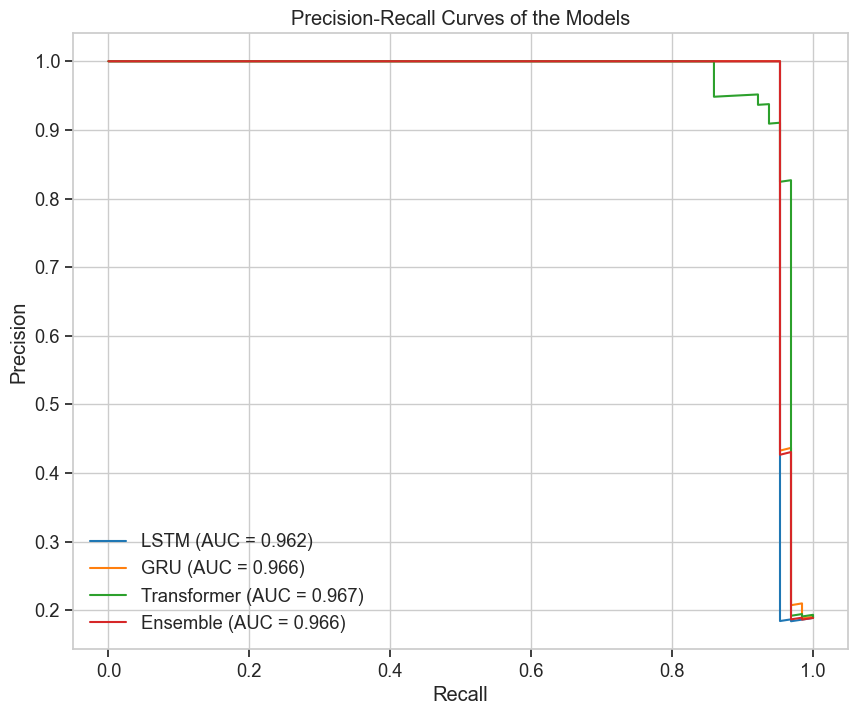

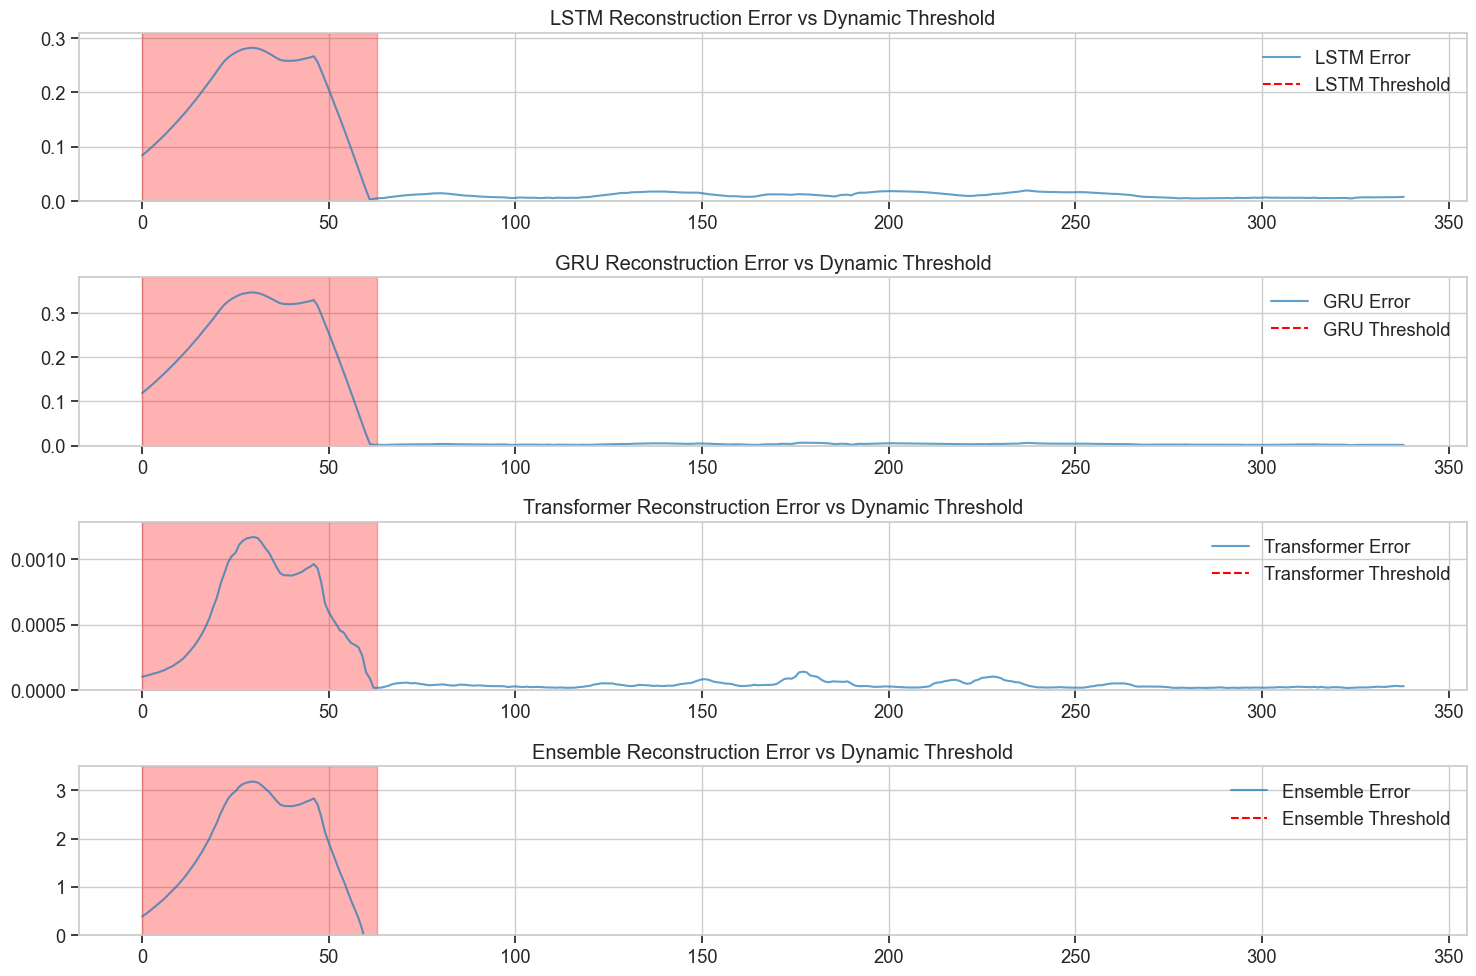

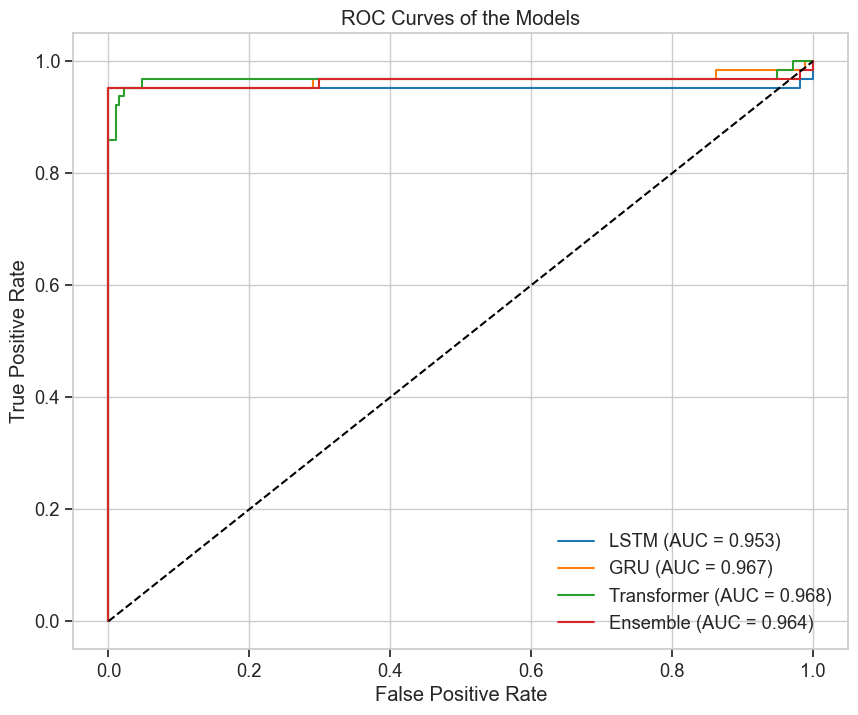

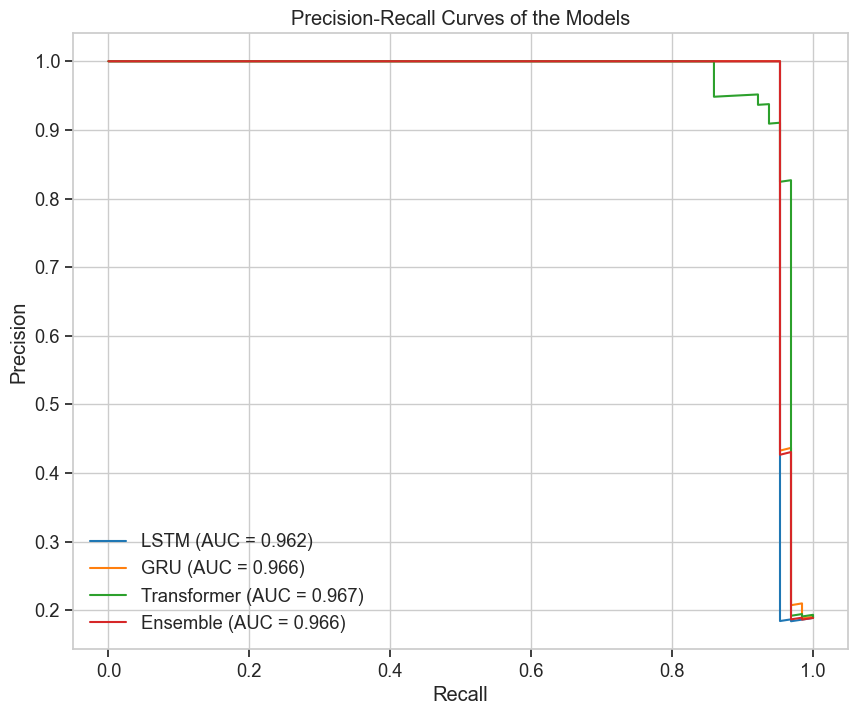

In [12]:

# Prepare results dictionary
results_dict = {
    'models': {
        'lstm': lstm_model,
        'gru': gru_model,
        'transformer': transformer_model,
        'ensemble': ensemble
    },
    'errors': {
        'lstm': lstm_errors,
        'gru': gru_errors,
        'transformer': transformer_errors,
        'ensemble': ensemble_errors
    },
    'thresholds': {
        'lstm': lstm_results['threshold'],
        'gru': gru_results['threshold'],
        'transformer': transformer_results['threshold'],
        'ensemble': ensemble_results['threshold']
    },
    'results': {
        'lstm': lstm_results,
        'gru': gru_results,
        'transformer': transformer_results,
        'ensemble': ensemble_results
    },
    'data': {
        'X_test': X_test,
        'y_test': y_test,
        'lstm_orig': lstm_orig,
        'lstm_recon': lstm_recon,
        'timestamps': timestamps
    },
    'interpreter': interpreter
}

# Visualize results
visualize_results(results_dict)
plot_roc_curves(results_dict)
plot_precision_recall_curves(results_dict)


### 8. Save Trained Models

In [13]:

# Save models
config = {
    "sequence_length": sequence_length,
    "embedding_dim": 64
}

save_trained_models(
    models_dict={
        "lstm": lstm_model,
        "gru": gru_model,
        "transformer": transformer_model
    },
    results_dict={
        "lstm": lstm_results,
        "gru": gru_results,
        "transformer": transformer_results,
        "ensemble": ensemble_results
    },
    config=config,
    base_path="models/autoencoder/"
)

2025-05-23 21:41:09,129 - INFO - Modelo lstm guardado en models/autoencoder/lstm_model.pt
2025-05-23 21:41:09,133 - INFO - Modelo gru guardado en models/autoencoder/gru_model.pt
2025-05-23 21:41:09,137 - INFO - Modelo transformer guardado en models/autoencoder/transformer_model.pt
2025-05-23 21:41:09,138 - INFO - Metadatos guardados en models/autoencoder/model_metadata.json
